## Particle tracking through a steady-state flow field on a structured grid

Application of a MODFLOW 6 particle-tracking (PRT) model to solve example 1 from the MODPATH 7 documentation.

This example problem involves a flow system consisting of two aquifers separated by a low conductivity confining layer, modeled on a nearly square structured grid with uniform square cells. There is a single well in the center of the grid, with a river running along the grid's right-hand boundary.

In part A, 21 particles are released at the water table in layer 1, all along the grid's third column, and tracked until discharge locations are reached. Some of the particles discharge to the well, while some discharge to the river.

In part B, 9 particles are released from points evenly distributed over the top faces of all cells in layer 1, then the capture zones of the river and the central well are computed.

### Problem setup

In [47]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import numpy as np
from pathlib import Path

sys.path.append(os.path.join("..", "common"))
import config
from figspecs import USGSFigure

Define figure properties.

In [48]:
# figure_size
figure_size = (12.5, 4.5)

# Pathline and starting point colors by capture destination
colordest = dict.fromkeys(['well', 'river'], "blue")
colordest['well'] = "red"

Base simulation and model name and workspace

In [49]:
sim_name = "mp7-p01"
gwf_name = sim_name
prt_name = sim_name + "_prt"
mp7_name = sim_name + "_mp7"
example_name = "ex-prt-" + sim_name

ws = config.base_ws
sim_ws = Path(ws) / example_name
mf6_ws = sim_ws / "mf6"
mp7_ws = sim_ws / "mp7"

mf6_ws.mkdir(exist_ok=True, parents=True)
mp7_ws.mkdir(exist_ok=True, parents=True)

headfile = "{}.hds".format(gwf_name)
budgetfile = "{}.cbb".format(gwf_name)
budgetfile_prt = "{}.cbb".format(prt_name)

Define model units.

In [50]:
length_units = "feet"
time_units = "days"

Define time discretization parameters.

In [51]:
nper, nstp, perlen, tsmult = 1, 1, 1.0, 1.0

Define MODFLOW 6 flow model parameters.

In [52]:
# Grid
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.0
top = 400.0
botm = [220.0, 200.0, 0.0]

# Layer types
laytyp = [1, 0, 0]

# Conductivities
kh = [50.0, 0.01, 200.0]
kv = [10.0, 0.01, 20.0]

# Well
wel_loc = (2, 10, 9)
wel_q = -150000.0

# Recharge
rch = 0.005
rch_iface = 6
rch_iflowface = -1

# River
riv_h = 320.0
riv_z = 317.0
riv_c = 1.0e5
riv_iface = 6
riv_iflowface = -1

Define data for the MODFLOW 6 well and river packages.

In [53]:
# Well package
wd = [(wel_loc, wel_q)]

# River package
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z, riv_iface, riv_iflowface])

Define shared MODFLOW 6 PRT and MODPATH 7 particle-tracking model parameters.

In [54]:
# Porosity
porosity = 0.1

# Zones
def_zone = 1
wel_zone = 2
zones_lay1 = def_zone
zones_lay2 = def_zone
zones_lay3 = np.full((nrow, ncol), def_zone, dtype=np.int32)
zones_lay3[wel_loc[1:]] = wel_zone

# Starting location template size for example 1B;
# in the original example, there is initially a
# 3x3 array of particles in each cell in layer 1;
# in this example, there is initially one
# particle in each cell in layer 1; the original
# 3x3 particle arrays can be restored simply by
# setting sloc_tmpl_size below to 3 instead of 1.
sloc_tmpl_size = 1

Define MODPATH 7 model parameters.

In [55]:
# Zones
zones = [zones_lay1, zones_lay2, zones_lay3]

# Default iface
defaultiface = {"RCH": 6, "EVT": 6}

Define particle release point data for the MODFLOW 6 PRT particle-tracking model.

In [56]:
# Example 1A
releasepts = {}
releasepts['1A'] = []
zrpt = top
k = 0
j = 2
for i in range(nrow):
    nrpt = i
    xrpt = (j + 0.5) * delr
    yrpt = (nrow - i - 0.5) * delc
    rpt = [nrpt, k, i, j, xrpt, yrpt, zrpt]
    releasepts['1A'].append(rpt)

# Example 1B
releasepts['1B'] = []
ndivc = sloc_tmpl_size
ndivr = sloc_tmpl_size
deldivc = delc / ndivc
deldivr = delr / ndivr
k = 0
zrpt = top
nrpt = -1
for i in range(nrow):
    y0 = (nrow - i - 1) * delc
    for j in range(ncol):
        x0 = j * delr
        for idiv in range(ndivc):
            dy = (idiv + 0.5) * deldivc
            yrpt = y0 + dy
            for jdiv in range(ndivr):
                dx = (jdiv + 0.5) * deldivr
                xrpt = x0 + dx
                nrpt += 1
                rpt = [nrpt, k, i, j, xrpt, yrpt, zrpt]
                releasepts['1B'].append(rpt)

Define particle data for the MODPATH 7 model

In [57]:
# Example 1A
plocs = []
pids = []
for idx in range(nrow):
    plocs.append((0, idx, 2))
    pids.append(idx)
# issue(flopyex): in the flopy example this notebook is based on,
#  localz is not set to 1.0 like in the MODPATH examples doc,
#  so it defaults to 0.5, but it shouldn't really matter because
#  the particle gets placed at the water table anyway
part0 = flopy.modpath.ParticleData(
    plocs, drape=0, structured=True, particleids=pids, localz=1.0
)

# Example 1B
divs = sloc_tmpl_size
locs1b = [[0, 0, 0, 0, nrow - 1, ncol - 1]]
sd = flopy.modpath.CellDataType(
    drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1
)
sd = flopy.modpath.FaceDataType(
    drape=0,
    verticaldivisions1=0, horizontaldivisions1=0,
    verticaldivisions2=0, horizontaldivisions2=0,
    verticaldivisions3=0, horizontaldivisions3=0,
    verticaldivisions4=0, horizontaldivisions4=0,
    rowdivisions5=0, columndivisions5=0,
    rowdivisions6=divs, columndivisions6=divs
)
p = flopy.modpath.LRCParticleData(
    subdivisiondata=[sd], lrcregions=[locs1b]
)

Define information used to extract and plot model results.

In [58]:
# Get well and river cell numbers
nodes = {}
k, i, j = wel_loc
nodes['well'] = ncol * (nrow * k + i) + j
nodes['river'] = []
for rivspec in rd:
    k, i, j = rivspec[0]
    node = ncol * (nrow * k + i) + j
    nodes['river'].append(node)

Define functions to build, write, run, and plot models. This example employs a shared MODFLOW 6 GWF + PRT simulation, and a separate MODPATH 7 simulation.

In [59]:
def build_model(example_name):
    print("Building models...{}".format(example_name))

    # ===============================
    # Create the MODFLOW 6 simulation
    # ===============================
    
    # Instantiate the MODFLOW 6 simulation object
    sim = flopy.mf6.MFSimulation(
        sim_name=gwf_name, exe_name="mf6", version="mf6", sim_ws=mf6_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    pd = (perlen, nstp, tsmult)
    flopy.mf6.modflow.mftdis.ModflowTdis(
        sim, pname="tdis", time_units="DAYS", nper=nper, perioddata=[pd]
    )

    # -------------------
    # Build the GWF model
    # -------------------

    # Instantiate the MODFLOW 6 gwf (groundwater-flow) model
    model_nam_file = "{}.nam".format(gwf_name)
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=gwf_name, model_nam_file=model_nam_file, save_flows=True
    )

    # Instantiate the MODFLOW 6 gwf discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        gwf,
        pname="dis",
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Instantiate the MODFLOW 6 gwf initial conditions package
    flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=top)

    # Instantiate the MODFLOW 6 gwf node property flow package
    flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
        gwf, pname="npf", icelltype=laytyp, k=kh, k33=kv,
        save_saturation=True, save_specific_discharge=True,
    )

    # Instantiate the MODFLOW 6 gwf recharge package
    flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(
        gwf, recharge=rch,
        auxiliary=["iface", "iflowface"], aux=[rch_iface, rch_iflowface],
    )

    # Instantiate the MODFLOW 6 gwf well package
    flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
        gwf, maxbound=1, stress_period_data={0: wd}
    )

    # Instantiate the MODFLOW 6 gwf river package
    flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
        gwf, auxiliary=["iface", "iflowface"], stress_period_data={0: rd}
    )

    # Instantiate the MODFLOW 6 gwf output control package
    head_record = [headfile]
    budget_record = [budgetfile]
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
    flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
        gwf,
        pname="oc",
        saverecord=saverecord,
        head_filerecord=head_record,
        budget_filerecord=budget_record,
    )

    # -------------------
    # Build the PRT model
    # -------------------

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        sim, modelname=prt_name, model_nam_file="{}.nam".format(prt_name)
    )

    # Instantiate the MODFLOW 6 prt discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        prt, pname="dis",
        nlay=nlay, nrow=nrow, ncol=ncol,
        length_units="FEET",
        delr=delr, delc=delc,
        top=top, botm=botm,
    )

    # Instantiate the MODFLOW 6 prt model input package
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    # Instantiate the MODFLOW 6 prt particle release point (prp) package
    # for example 1A
    nreleasepts1a = len(releasepts['1A'])
    pd = {0: ["FIRST"],}
    flopy.mf6.ModflowPrtprp(
        prt, pname="prp1a", filename="{}_1a.prp".format(prt_name),
        nreleasepts=nreleasepts1a, packagedata=releasepts['1A'],
        perioddata=pd,
    )

    # Instantiate the MODFLOW 6 prt particle release point (prp) package
    # for example 1B
    nreleasepts1b = len(releasepts['1B'])
    pd = {0: ["FIRST"],}
    flopy.mf6.ModflowPrtprp(
        prt, pname="prp1b", filename="{}_1b.prp".format(prt_name),
        nreleasepts=nreleasepts1b, packagedata=releasepts['1B'],
        perioddata=pd,
    )

    # Instantiate the MODFLOW 6 prt output control package
    budget_record = [budgetfile_prt]
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    flopy.mf6.ModflowPrtfmi(prt)

    # Create the MODFLOW 6 gwf-prt model exchange
    flopy.mf6.ModflowGwfprt(
        sim, exgtype="GWF6-PRT6",
        exgmnamea=gwf_name, exgmnameb=prt_name,
        filename="{}.gwfprt".format(gwf_name),
    )
    
    #--------------------------------------------------
    # Create solutions for the models in the simulation
    #--------------------------------------------------

    # Create an iterative model solution (IMS) for the MODFLOW 6 gwf model
    ims = flopy.mf6.ModflowIms(
        sim, pname="ims",
        complexity="SIMPLE",
        outer_dvclose=1e-6, inner_dvclose=1e-6,
        rcloserecord=1e-6,
    )

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        sim, pname="ems",
        filename="{}.ems".format(prt_name),
    )
    sim.register_solution_package(ems, [prt.name])

    # ===============================
    # Create the MODPATH 7 simulation
    # ===============================

    # Instantiate the MODPATH 7 simulation object
    mp7 = flopy.modpath.Modpath7(
        modelname=mp7_name, flowmodel=gwf, exe_name="mp7", model_ws=mp7_ws,
        budgetfilename=budgetfile, headfilename=headfile
    )

    # Instantiate the MODPATH 7 basic data
    flopy.modpath.Modpath7Bas(mp7, porosity=porosity, defaultiface=defaultiface)

    # Instantiate the MODPATH 7 particle groups
    pg1a = flopy.modpath.ParticleGroup(
        particlegroupname="PG1A", particledata=part0, filename=sim_name + "a.sloc"
    )
    pg1b = flopy.modpath.ParticleGroupLRCTemplate(
        particlegroupname="PG1B", particledata=p, filename=sim_name + "b.sloc"
    )

    # Instantiate the MODPATH 7 simulation data
    mpsim = flopy.modpath.Modpath7Sim(
        mp7,
        simulationtype="combined",
        trackingdirection="forward",
        weaksinkoption="pass_through",
        weaksourceoption="pass_through",
        budgetoutputoption="summary",
        referencetime=[0, 0, 0.0],
        stoptimeoption="extend",
        timepointdata=[500, 1000.0],
        zonedataoption="on",
        zones=zones,
        particlegroups=[pg1a, pg1b],
    )
    
    #=======================
    # Return the simulations
    #=======================

    return sim, mp7

Define a function to write model files.

In [60]:
def write_model(sim, mp7, silent=True):
    sim.write_simulation(silent=silent)
    mp7.write_input()

Define a function to run the models.

In [61]:
@config.timeit
def run_model(sim, mp7, silent=True):
    # Run MODFLOW 6 simulation
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success
    for line in buff:
        print(line)
    
    # Run MODPATH 7 simulation
    success, buff = mp7.run_model(silent=silent, report=True)
    assert success
    for line in buff:
        print(line)

    return success

Define functions to load pathline data from MODFLOW 6 output files.

In [62]:
def load_mf6pathlines(cbb):
    """Utility function for reading and storing MODFLOW 6 PRT pathlines"""

    ncpl = nrow * ncol
    dtype={'names':['x','y','z','time','k','particleid'],
           'formats':['<f4','<f4','<f4','<f4','<i4','<i4'],
          }
    upn = cbb.get_unique_package_names(decode=True)
    times = cbb.get_times()

    # Extract pathline data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mf6pathlines = {}
    for prpnam in upn:
        subprob = prpnam.strip()[-2:]
        pdict = {}
        # For each time, read and parse particle data written by the prp
        # and add it to a dictionary keyed on a particle identifier consisting
        # of release point number and release time
        for totim in times:
            data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
            for ploc in data[0]:
                # Particle data read from the binary output file are in terms
                # of one-based indexing; will convert to zero-based indexing
                irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
                irpt -= 1
                node -= 1
                kp = node // ncpl
                # issue(mf6): particle ids not assigned yet in mf6
                pathpoint = (xp, yp, zp, ttrack, kp, 0)
                key = (irpt, trelease)
                # Note that repeat locations written for terminated particles
                # are not filtered out here, though they could be
                if key not in pdict:
                    pdict[key] = [pathpoint]
                else:
                    pdict[key].append(pathpoint)
        # Sort the dictionary into separate dictionaries of formatted arrays
        # for pathlines ending at the well and pathlines ending at the river
        mf6pathlines[(subprob, 'well')] = []
        mf6pathlines[(subprob, 'river')] = []
        for key in pdict:
            path = np.core.records.fromarrays(np.array(pdict[key]).T, dtype=dtype)
            # issue(mf6): zone info not stored with particle locations, so using
            #   layer number to determine endpoint zone (well or river) in this problem
            if path['k'][-1] == 2:
                mf6pathlines[(subprob, 'well')].append(path)
            else:
                mf6pathlines[(subprob, 'river')].append(path)
                    
    # Return mf6pathlines
    return mf6pathlines

def load_mf6endpointdata(cbb):
    """Utility function for reading and storing MODFLOW 6 PRT endpoint data"""

    ncpl = nrow * ncol
    dtype={'names':['time0','time',
                    'node0','k0','x0','y0','z0',
                    'node','k','x','y','z',
                    'zone'],
           'formats':['<f4','<f4',
                      '<i4','<i4','<f4','<f4','<f4',
                      '<i4','<i4','<f4','<f4','<f4',
                      '<i4'],
          }
    upn = cbb.get_unique_package_names(decode=True)
    times = cbb.get_times()

    # Extract endpoint data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mf6endpointdata = {}
    for prpnam in upn:
        subprob = prpnam.strip()[-2:]
        edict = {}
        # For each time, read and parse particle data written by the prp
        # and store it in a dictionary keyed on a particle identifier consisting
        # of release point number and release time; later data overwrite earlier
        # data for the same key, ultimately resulting in the endpoint being stored;
        # alternatively, could read backwards in time, but would still need to
        # deal with repeat locations for terminated particles
        for totim in times:
            data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
            for ploc in data[0]:
                # Particle data read from the binary output file are in terms
                # of one-based indexing; will convert to zero-based indexing
                irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
                irpt -= 1
                node -= 1
                key = (subprob, irpt, trelease)
                # To facilitate meaningful travel times, filter out repeat locations
                # written for terminated particles
                if (key not in edict) or \
                node != edict[key][7] or xp != edict[key][9] or \
                yp != edict[key][10] or zp != edict[key][11]:
                    rpt = releasepts[subprob][irpt]
                    krls, irls, jrls = [rpt[i] for i in (1, 2, 3)]
                    noderls = ncol * (nrow * krls + irls) + jrls
                    xrls = rpt[4]
                    yrls = rpt[5]
                    zrls = rpt[6]
                    kp = node // ncpl
                    # issue(mf6): zone info not stored with particle locations, so using
                    #   layer number to determine endpoint zone (well or river) in this problem
                    if kp == 2:
                        zone = 1
                    else:
                        zone = 0
                    # issue(mf6): particle ids not assigned yet in mf6
                    edict[key] = (trelease, ttrack,
                                  noderls, krls, xrls, yrls, zrls,
                                  node, kp, xp, yp, zp,
                                  zone)
        # Sort the dictionary into separate dictionaries of formatted arrays
        # for endpoints at the well and endpoints at the river
        mf6endpointdata[(subprob, 'well')] = []
        mf6endpointdata[(subprob, 'river')] = []
        for key in edict:
            if edict[key][-1] == 1:
                mf6endpointdata[(subprob, 'well')].append(edict[key])
            else:
                mf6endpointdata[(subprob, 'river')].append(edict[key])
        mf6endpointdata[(subprob, 'well')] = np.rec.array(mf6endpointdata[(subprob, 'well')], dtype=dtype)
        mf6endpointdata[(subprob, 'river')] = np.rec.array(mf6endpointdata[(subprob, 'river')], dtype=dtype)

    # Merge endpoint data for particles that terminate in the well
    # and particles that terminate in the river
    for subprob in ['1A', '1B']:
        mf6endpointdata[(subprob, 'all')] = np.concatenate((mf6endpointdata[(subprob, 'well')],
                                                            mf6endpointdata[(subprob, 'river')]))

    # Return mf6endpointdata
    return mf6endpointdata

Define a utility function for reading MODPATH 7 pathlines from output files.

In [63]:
def load_mp7pathlines(plf):

    # Extract pathline data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mp7pathlines = {}
    for dest in ['well', 'river']:
        pdata = plf.get_destination_pathline_data(nodes[dest], to_recarray=True)
        for pgidx, subprob in enumerate(['1A', '1B']):
            mp7pathlines[(subprob, dest)] = np.array([point for point in pdata
                                                      if point['particlegroup'] == pgidx],
                                                     dtype=pdata.dtype)

    # Return mp7pathlines
    return mp7pathlines

Define a utility function for reading MODPATH 7 endpoint data from output files.

In [64]:
def load_mp7endpointdata(epf):

    # Extract endpoint data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mp7endpointdata = {}
    for dest in ['well', 'river']:
        epd = epf.get_destination_endpoint_data(dest_cells=nodes[dest])
        for pgidx, subprob in enumerate(['1A', '1B']):
            mp7endpointdata[(subprob, dest)] = np.array([point for point in epd
                                                         if point['particlegroup'] == pgidx],
                                                         dtype=epd.dtype)

    # Merge endpoint data for particles that terminate in the well
    # and particles that terminate in the river
    for subprob in ['1A', '1B']:
        mp7endpointdata[(subprob, 'all')] = np.concatenate((mp7endpointdata[(subprob, 'well')],
                                                            mp7endpointdata[(subprob, 'river')]))

    # Return mp7endpointdata
    return mp7endpointdata

Define a utility function for plotting pathlines, optionally colored by capture destination.

In [65]:
def plot_pathlines(ax, gwf, pathlines, subprob, plottitle, **kwargs):

    ax.set_title(plottitle, fontsize=12)
    ax.set_aspect('equal')
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5)
    
    for dest in ['well', 'river']:
        label = None
        if 'colordest' in kwargs:
            # Use colordest to color pathlines by capture destination
            color = kwargs['colordest'][dest]
            label = "captured by " + dest
        elif 'color' in kwargs:
            # Use the specified color for all pathlines
            color = kwargs['color']
        else:
            # Use a default color for all pathlines
            color = "blue"
        mm.plot_pathline(
            pathlines[(subprob, dest)], layer="all",
            colors=[color], label=label)
        if label != None:
            ax.legend()

    return

Define a utility function for plotting particle starting points, colored by capture destination or travel time to capture.

In [66]:
def plot_startpts(ax, gwf, endpointdata, subprob, plottitle, **kwargs):

    ax.set_title(plottitle, fontsize=12)
    ax.set_aspect('equal')
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5)
    startingpoint_markersize = 5

    if 'colordest' in kwargs:
        # Use colordest to color starting points by capture destination
        for dest in ['well', 'river']:
            color = kwargs['colordest'][dest]
            label = "captured by " + dest
            # issue(flopy): since plot_endpoint always sets kwarg c to something,
            #   kwarg color conflicts with c if you try to set color; temporarily
            #   modified plot_endpoint (map.py) in my flopy installation to check
            #   for color before setting default for c, so there's no conflict;
            #   will ask Josh about implementing this permanently
            mm.plot_endpoint(
                endpointdata[(subprob, dest)], direction="starting",
                s=startingpoint_markersize, color=color,
                label=label
            )
            ax.legend()
    else:
        # Color starting points by travel time to capture
        mm.plot_endpoint(
            endpointdata[(subprob, 'all')], direction="starting",
            s=startingpoint_markersize, colorbar=True, shrink=0.25
        )
    
    return

Define a wrapper function to plot all results.

In [67]:
def plot_results(sim, mp7, idx):
    
    import flopy.utils.binaryfile as bf

    # MODFLOW 6 PRT budget file
    fpth = mf6_ws / budgetfile_prt
    cbb = bf.CellBudgetFile(fpth)

    # Load MODFLOW 6 PRT pathlines
    mf6pathlines = load_mf6pathlines(cbb)
    
    # Load MODFLOW 6 PRT endpoint data
    mf6endpointdata = load_mf6endpointdata(cbb)

    # Load MODPATH 7 pathlines
    fpth = os.path.join(mp7_ws, mp7_name + ".mppth")
    plf = flopy.utils.PathlineFile(fpth)
    mp7pathlines = load_mp7pathlines(plf)
    
    # Load MODPATH 7 endpoint data
    fpth = os.path.join(mp7_ws, mp7_name + ".mpend")
    epf = flopy.utils.EndpointFile(fpth)
    mp7endpointdata = load_mp7endpointdata(epf)

    # Get gwf model
    gwf = sim.get_model(gwf_name)

    # ==========
    # Example 1A
    # ==========

    # --------------------------------------------------------
    # Pathlines colored by capture destination (well or river)
    # --------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(t='Example 1A - Pathlines colored by capture destination (well or river)',
                 fontsize=14, y=1.05)
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_pathlines(ax, gwf, mf6pathlines, '1A', 'MODFLOW 6 PRT', colordest=colordest)

    # MODPATH 7
    ax = axes[1]
    plot_pathlines(ax, gwf, mp7pathlines, '1A', 'MODPATH 7', colordest=colordest)
    # issue: the pathlines in the right-hand plot appear not to go
    #   go quite as far, despite their being the same as the ones
    #   on the left; axis scaling issue?

    # Save figure
    if config.plotSave:
        fpth = os.path.join(
            "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
        )
        fig.savefig(fpth)

    # ==========
    # Example 1B
    # ==========

    # --------------------------------------------------------
    # Pathlines colored by capture destination (well or river)
    # --------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(t='Example 1B - Pathlines colored by capture destination (well or river)',
                 fontsize=14, y=1.05)
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_pathlines(ax, gwf, mf6pathlines, '1B', 'MODFLOW 6 PRT', colordest=colordest)

    # MODPATH 7
    ax = axes[1]
    plot_pathlines(ax, gwf, mp7pathlines, '1B', 'MODPATH 7', colordest=colordest)

    # Save figure
    if config.plotSave:
        fpth = os.path.join(
            "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
        )
        fig.savefig(fpth)

    # -----------------------------------------------------------------------
    # Particle starting points colored by capture destination (well or river)
    # -----------------------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(t='Example 1B - Particle starting points colored by capture destination (well or river)',
                 fontsize=14, y=1.05)
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_startpts(ax, gwf, mf6endpointdata, '1B', 'MODFLOW 6 PRT', colordest=colordest)

    # MODPATH 7
    ax = axes[1]
    plot_startpts(ax, gwf, mp7endpointdata, '1B', 'MODPATH 7', colordest=colordest)

    # Save figure
    if config.plotSave:
        fpth = os.path.join(
            "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
        )
        fig.savefig(fpth)

    # ----------------------------------------------------------
    # Particle starting points colored by travel time to capture
    # ----------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(t='Example 1B - Particle starting points colored by travel time to capture',
                 fontsize=14, y=1.05)
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_startpts(ax, gwf, mf6endpointdata, '1B', 'MODFLOW 6 PRT')

    # MODPATH 7
    ax = axes[1]
    plot_startpts(ax, gwf, mp7endpointdata, '1B', 'MODPATH 7')

    # Save figure
    if config.plotSave:
        fpth = os.path.join(
            "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
        )
        fig.savefig(fpth)
        
    return

Define a function to wrap all of the steps for each scenario:

1. build model
2. write model
3. run model
4. plot results

In [68]:
def scenario(idx, silent=True):
    sim, mp7 = build_model(example_name)
    write_model(sim, mp7, silent=silent)
    run_model(sim, mp7, silent=silent)
    plot_results(sim, mp7, idx)

We are now ready to run the example problem. Subproblems 1A and 1B are solved by a single MODFLOW 6 run and a single MODPATH 7 run, so they are included under one "scenario". Each of the two subproblems is represented by its own particle release package (for MODFLOW 6) or particle group (for MODPATH 7).

Building models...ex-prt-mp7-p01
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.5.0 Release Candidate 12/09/2022
                               ***DEVELOP MODE***

        MODFLOW 6 compiled May 25 2023 15:57:19 with GCC version 13.1.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use of the software.


 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023

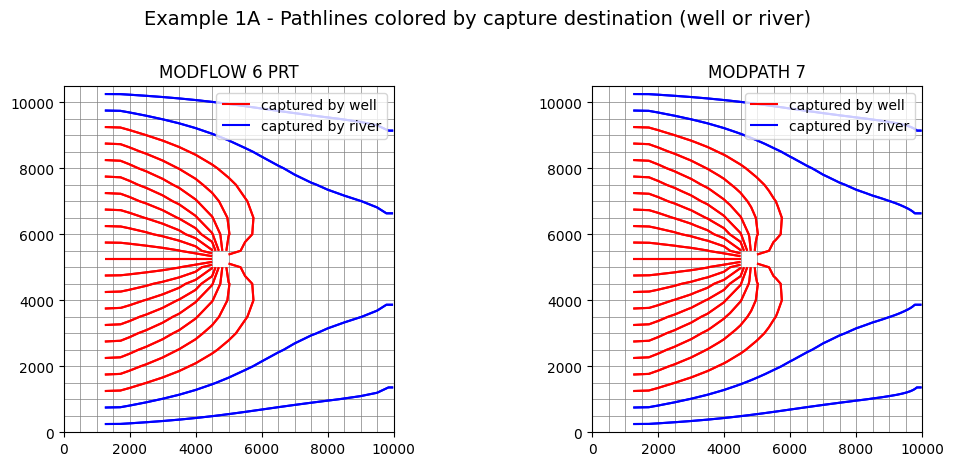

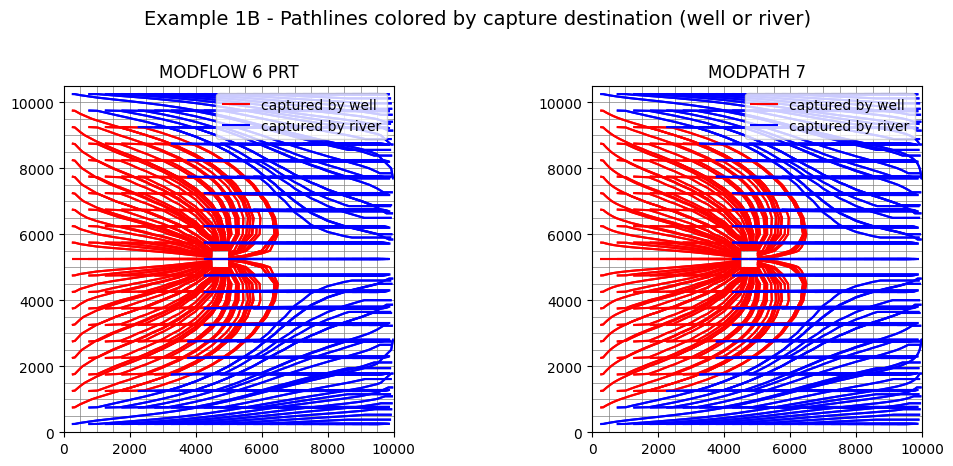

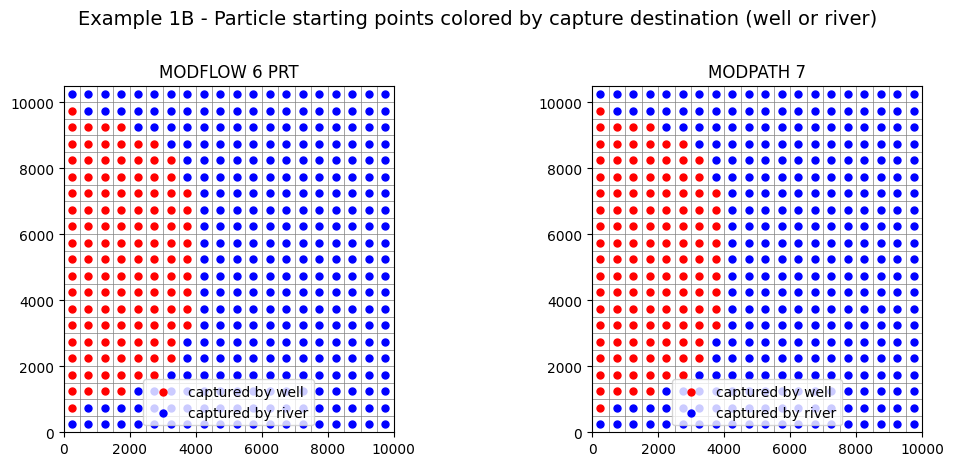

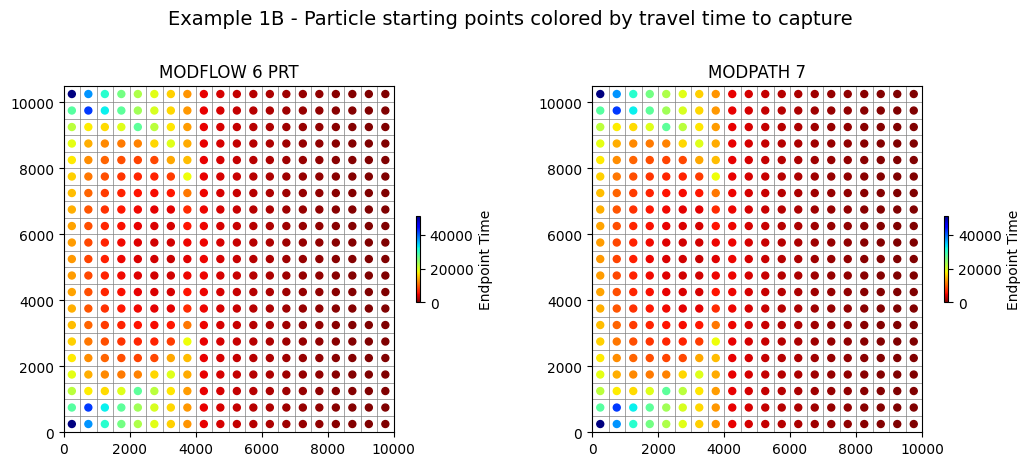

In [69]:
scenario(0)